JPMorgan Trading Exercise

In [2]:
# Load libraries
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression


In [3]:
#Loading the data

data = pd.read_csv("apples_exercise.csv")
data.head()

,Unnamed: 0,German Apples (EUR),UK Apples (GBP),EURGBP
0,2015-01-01,100.000000,119.158676,0.850000
1,2015-01-02,99.405545,117.280980,0.854055
2,2015-01-05,99.725345,117.678202,0.850161
3,2015-01-06,101.793753,121.447448,0.850128
4,2015-01-07,101.429514,122.719267,0.846781


<Axes: >

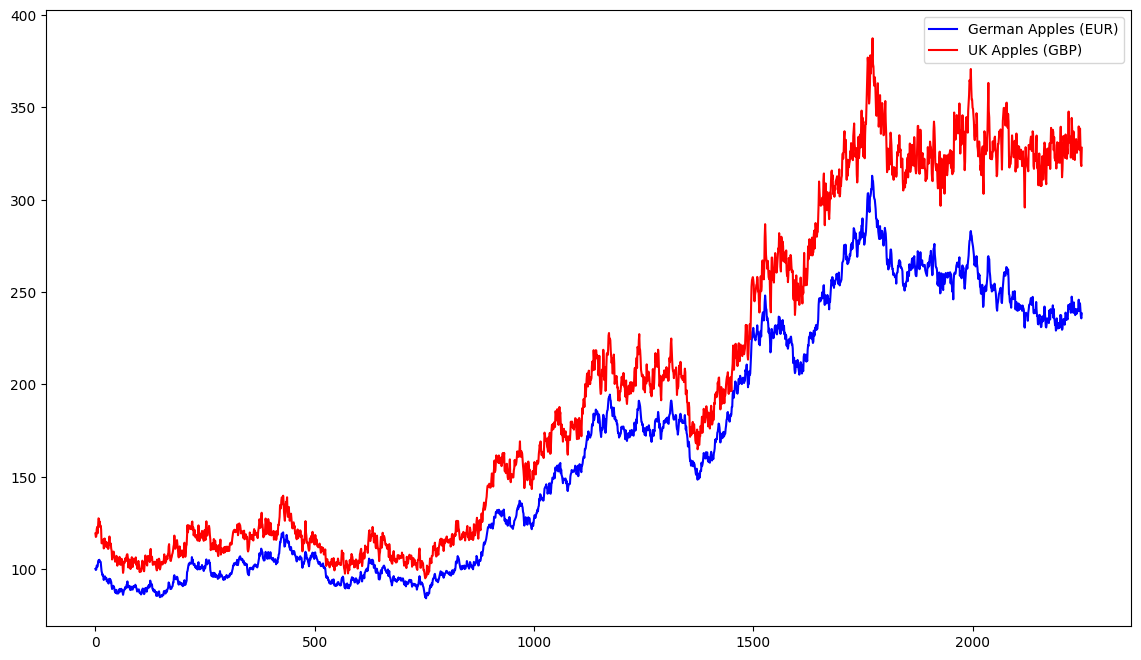

In [47]:
data[['German Apples (EUR)', 'UK Apples (GBP)']].plot(figsize = (14,8), color=['blue', 'red'])

,Unnamed: 0,German Apples (EUR),UK Apples (GBP),EURGBP,German Apples (GBP)
0,2015-01-01,100.000000,119.158676,0.850000,85.000000
1,2015-01-02,99.405545,117.280980,0.854055,84.897841
2,2015-01-05,99.725345,117.678202,0.850161,84.782559
3,2015-01-06,101.793753,121.447448,0.850128,86.537742
4,2015-01-07,101.429514,122.719267,0.846781,85.888621


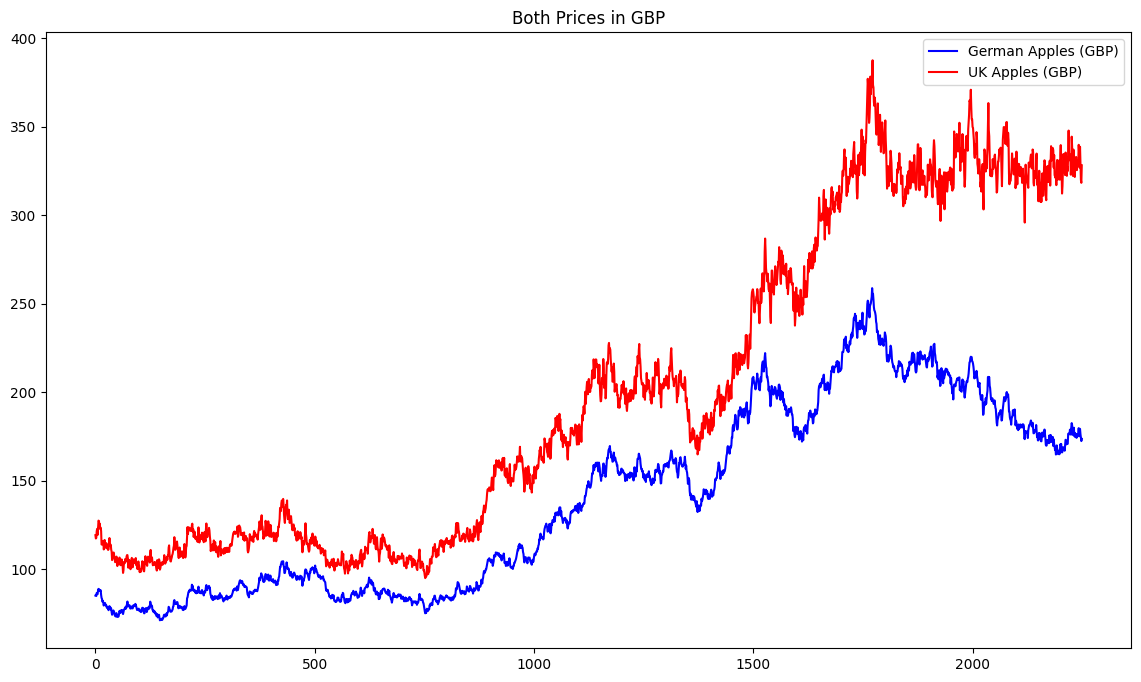

In [ ]:
#Converting the german price from EUR to GBP using the FX rate

data['German Apples (GBP)'] = data['German Apples (EUR)'] * data['EURGBP']
data[['German Apples (GBP)', 'UK Apples (GBP)']].plot(figsize = (14,8), color=['blue', 'red'], title = 'Both Prices in GBP')
data.head()

,Unnamed: 0,German Apples (EUR),UK Apples (GBP),EURGBP,German Apples (GBP),basis
0,2015-01-01,100.000000,119.158676,0.850000,85.000000,34.158676
1,2015-01-02,99.405545,117.280980,0.854055,84.897841,32.383139
2,2015-01-05,99.725345,117.678202,0.850161,84.782559,32.895644
3,2015-01-06,101.793753,121.447448,0.850128,86.537742,34.909706
4,2015-01-07,101.429514,122.719267,0.846781,85.888621,36.830645


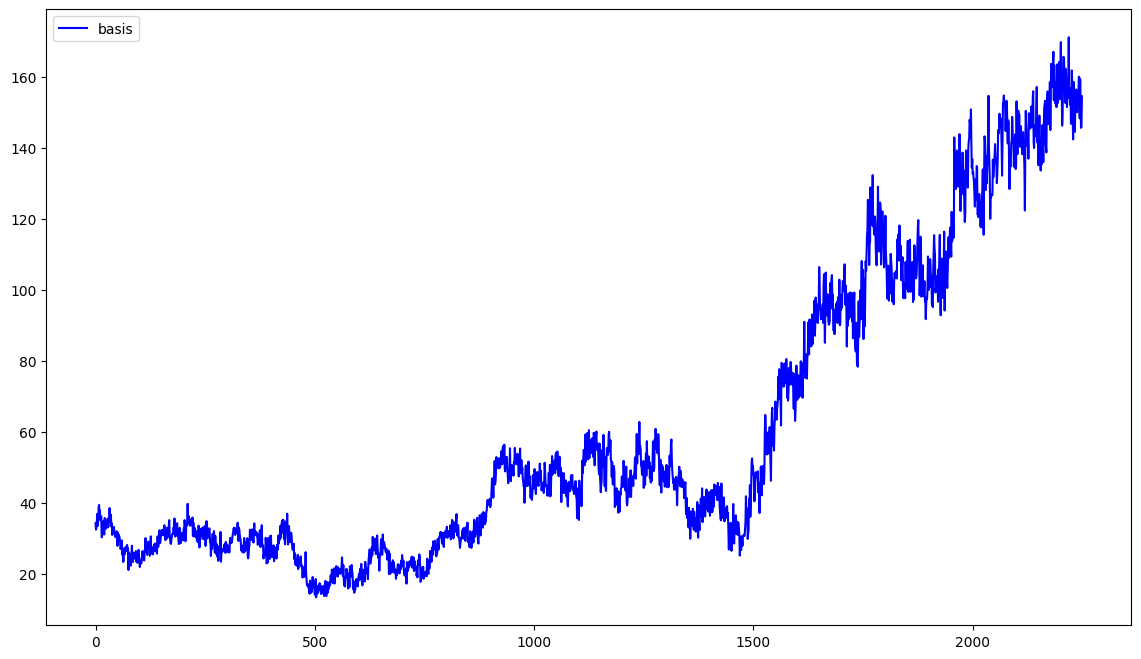

In [ ]:
#Computing and ploting the basis

data['basis'] = data['UK Apples (GBP)'] - data['German Apples (GBP)']
data[['basis']].plot(figsize = (14,8), color=['blue'])
data.head()

61.94140706198973 60.23810213011623
46.855704698334506 41.58193068478627


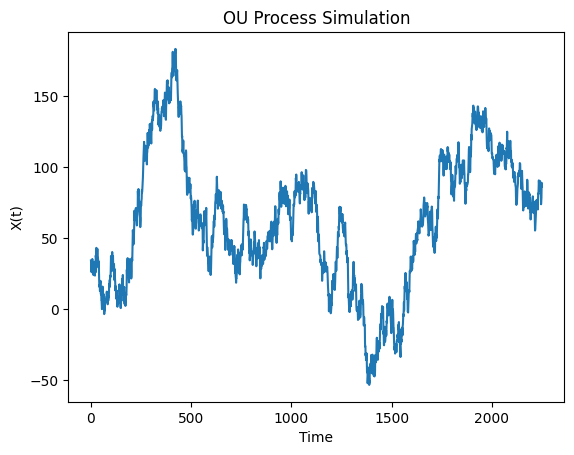

In [ ]:
# ---- OU process parameters ----

series = data['basis'].dropna().to_numpy()

T_uk = len(series)
dt = 1 
N_uk = int(T_uk/dt)

basis = np.zeros(N_uk)
basis[0] = series[0]

x_t = series[:-1]
x_next = series[1:]
A = np.vstack([np.ones_like(x_t), x_t]).T

beta, residuals, rank, s = np.linalg.lstsq(A, x_next, rcond=None)
c_hat_OU, phi_hat_OU = beta[0], beta[1]

epsilon_t_OU = x_next - c_hat_OU - phi_hat_OU * x_t
s_epsilon_OU = np.std(epsilon_t_OU, ddof=1)

theta_hat_OU = -np.log(phi_hat_OU)/dt
mu_hat_OU = c_hat_OU / (1 - phi_hat_OU)
sigma_hat_OU = s_epsilon_OU * np.sqrt(2 * theta_hat_OU / (1 - np.exp(-2 * theta_hat_OU * dt)))
e_term_OU = np.exp(-theta_hat_OU * dt)
std_step_OU = sigma_hat_OU * np.sqrt((1 - e_term_OU**2) / (2 * theta_hat_OU))

for t in range(1, N_uk):
    basis[t] = mu_hat_OU + (basis[t-1] - mu_hat_OU) * e_term_OU + std_step_OU * np.random.normal(0, 1)


print(np.mean(basis), data['basis'].mean())
print(np.std(basis, ddof=1), data['basis'].std())

plt.plot(np.linspace(0, T_uk, N_uk), basis)
plt.title("OU Process Simulation")
plt.xlabel("Time")
plt.ylabel("X(t)")
plt.show()



52.36998193046343 47.17452697183043


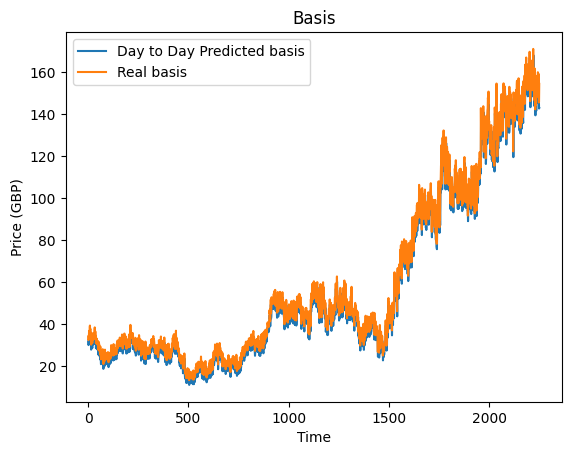

In [ ]:
#Test for the next day prediction of the basis using the OU parameters
x_t = series[:-1]
basis = mu_hat_OU + (x_t - mu_hat_OU) * e_term_OU + std_step_OU * np.random.normal(0, 1)

plt.plot(np.linspace(1, T_uk, N_uk-1),  basis, label = 'Day to Day Predicted basis')
plt.plot(np.linspace(1, T_uk, N_uk),data['basis'], label = 'Real basis')
plt.xlabel('Time')
plt.ylabel('Price (GBP)')
plt.title('Basis')
plt.legend()
plt.show()



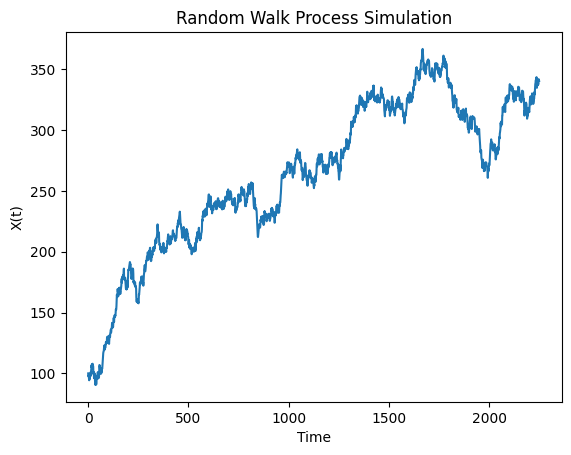

In [ ]:
# ---- Random walk parameters ----

German_apples = data['German Apples (EUR)'].dropna().to_numpy()
T_G = 2250
dt = 1
N_G = int(T_G/dt)

X_G = np.zeros(N_G)
X_G[0] = German_apples[0]

increments = np.diff(German_apples)
mu_hat_RW = np.mean(increments)
sigma_hat_RW = np.std(increments, ddof=1)

for t in range(1, T_G):                 #simulating a random walk using the parameters we extracted from our data
    dW = np.random.normal(0, 1)
    X_G[t] = X_G[t-1] + mu_hat_RW * dt + sigma_hat_RW * dW

plt.plot(np.linspace(0, T_G, N_G), X_G)
plt.title("Random Walk Process Simulation")
plt.xlabel("Time")
plt.ylabel("X(t)")
plt.show()

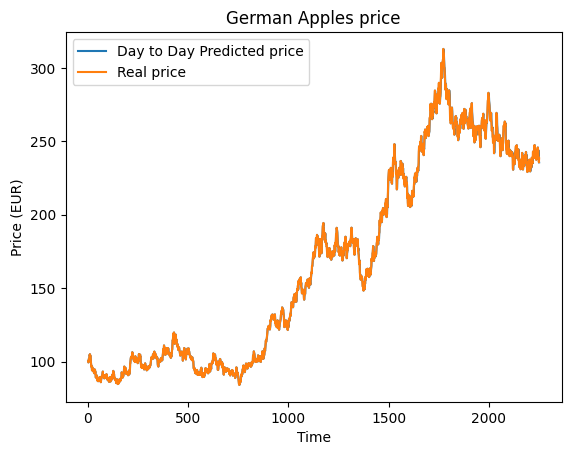

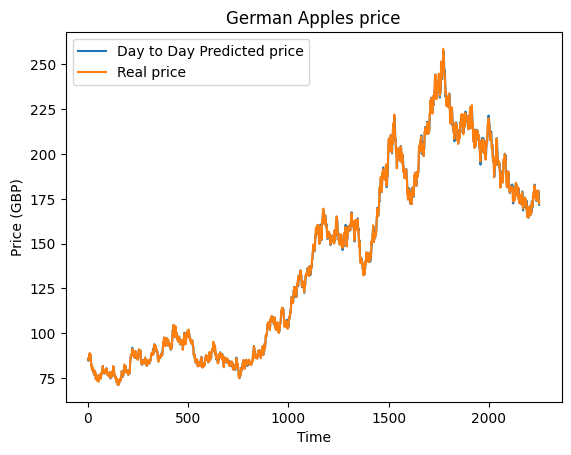

In [97]:
#Test for the next day prediction of the german price using the random walk parameters

series = data['German Apples (EUR)'].dropna().to_numpy()

x_t = series[:-1]
X_G = x_t + mu_hat_RW * dt + sigma_hat_RW * np.random.normal(0, 1)
plt.plot(np.linspace(1, T_uk, N_uk-1),  x_t, label = 'Day to Day Predicted price')
plt.plot(np.linspace(1, T_uk, N_uk),data['German Apples (EUR)'], label = 'Real price')
plt.xlabel('Time')
plt.ylabel('Price (EUR)')
plt.title('German Apples price')
plt.legend()
plt.show()

plt.plot(np.linspace(1, T_uk, N_uk-1),  x_t * data['EURGBP'][1:], label = 'Day to Day Predicted price')
plt.plot(np.linspace(1, T_uk, N_uk),data['German Apples (GBP)'], label = 'Real price')
plt.xlabel('Time')
plt.ylabel('Price (GBP)')
plt.title('German Apples price')
plt.legend()
plt.show()

155.3572610449447 154.6000669369055


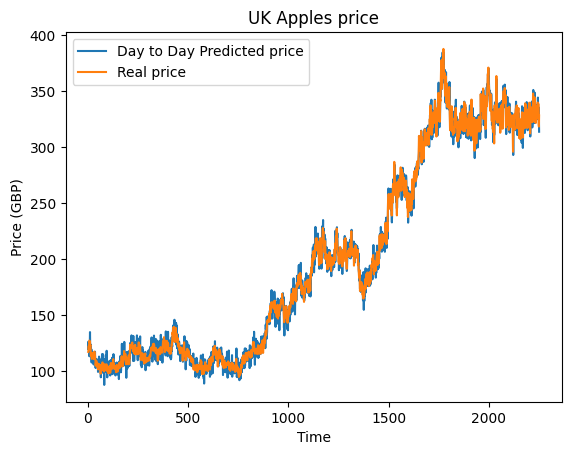

In [95]:
#UK price predictor

def UK_predictor(t):
    basis_t = mu_hat_OU + (data['basis'][t-1] - mu_hat_OU) * e_term_OU + std_step_OU * np.random.normal(0, 1)
    German_EUR_t = data['German Apples (EUR)'][t-1] + mu_hat_RW * dt + sigma_hat_RW * np.random.normal(0, 1)
    German_GBP_t = German_EUR_t * data['EURGBP'][t]
    UK_GBP_t = basis_t + German_GBP_t
    return UK_GBP_t

print(UK_predictor(1000), data['UK Apples (GBP)'][1000])

UK_predicted = np.zeros(N_G - 1)
for t in range(1, T_G):
    UK_predicted[t-1] = UK_predictor(t)

plt.plot(np.linspace(1, T_G, N_G-1), UK_predicted, label = 'Day to Day Predicted price')
plt.plot(np.linspace(1, T_G, N_G-1),data['UK Apples (GBP)'][1:], label = 'Real price')
plt.xlabel('Time')
plt.ylabel('Price (GBP)')
plt.title('UK Apples price')
plt.legend()
plt.show()

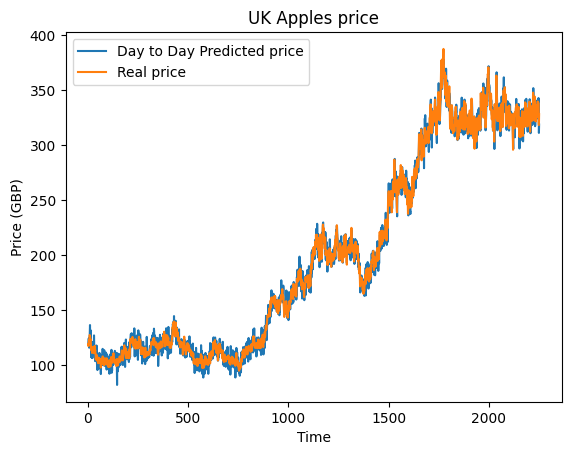

In [5]:
#Complete code with the trading strategy implemented

# Load libraries
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import plotly.express as px

data = pd.read_csv("apples_exercise.csv")
data['German Apples (GBP)'] = data['German Apples (EUR)'] * data['EURGBP'] #convert the german price in GBP
data['basis'] = data['UK Apples (GBP)'] - data['German Apples (GBP)'] #compute the basis

# ---- OU process parameters ----

series = data['basis'].dropna().to_numpy()

T_uk = len(series)
dt = 1 
N_uk = int(T_uk/dt)

x_t = series[:-1]
x_next = series[1:]
A = np.vstack([np.ones_like(x_t), x_t]).T


# Fit OU model via OLS: X_{t+1} = c + phi*X_t + epsilon
beta, residuals, rank, s = np.linalg.lstsq(A, x_next, rcond=None)  #OLS
c_hat_OU, phi_hat_OU = beta[0], beta[1]

epsilon_t_OU = x_next - c_hat_OU - phi_hat_OU * x_t #getting the random noise

s_epsilon_OU = np.std(epsilon_t_OU, ddof=1) # volatility of residuals

# Convert discrete-time parameters to continuous-time OU parameters
theta_hat_OU = -np.log(phi_hat_OU)/dt           # mean reversion speed
mu_hat_OU = c_hat_OU / (1 - phi_hat_OU)         # long-term mean
sigma_hat_OU = s_epsilon_OU * np.sqrt(2 * theta_hat_OU / (1 - np.exp(-2 * theta_hat_OU * dt)))
e_term_OU = np.exp(-theta_hat_OU * dt)
std_step_OU = sigma_hat_OU * np.sqrt((1 - e_term_OU**2) / (2 * theta_hat_OU))


# ---- Random walk parameters ----

German_apples = data['German Apples (EUR)'].dropna().to_numpy()
T_G = len(German_apples)
dt = 1
N_G = int(T_G/dt)

X_G = np.zeros(N_G)
X_G[0] = German_apples[0]

#Computing the parameters of the Random Walk
increments = np.diff(German_apples)
mu_hat_RW = np.mean(increments)
sigma_hat_RW = np.std(increments, ddof=1)


#UK price predictor
def UK_predictor(t):
    basis_t = mu_hat_OU + (data['basis'][t-1] - mu_hat_OU) * e_term_OU + std_step_OU * np.random.normal(0, 1) #basis @ t using basis @ t-1 and the OU parameters
    German_EUR_t = data['German Apples (EUR)'][t-1] + mu_hat_RW * dt + sigma_hat_RW * np.random.normal(0, 1) #German price @ t using the price @ t-1 and the random walk parameters
    German_GBP_t = German_EUR_t * data['EURGBP'][t] #conversion to GBP using the FX rate at t
    UK_GBP_t = basis_t + German_GBP_t #UK price @ t using basis @ t and german price @ t
    return UK_GBP_t

UK_predicted = np.zeros(N_G)
UK_predicted[0] = data['UK Apples (GBP)'][0]
for t in range(1, T_G):
    UK_predicted[t] = UK_predictor(t) #day to day prediction using the precedent day data

plt.plot(np.linspace(1, T_G, N_G), UK_predicted, label = 'Day to Day Predicted price')
plt.plot(np.linspace(1, T_G, N_G),data['UK Apples (GBP)'], label = 'Real price')
plt.xlabel('Time')
plt.ylabel('Price (GBP)')
plt.title('UK Apples price')
plt.legend()
plt.show()

data['Predicted UK'] = UK_predicted
data['delta'] = UK_predicted[:len(data)-1] - data['UK Apples (GBP)'][:-1] #compute the expected market variation for the next day
data['signal'] = np.where(data['delta'] > 0, 1, -1) #trading signal, long when we expect the market to go up (UK_predicted[t]>UK price[t-1]), short if the market go down (UK_predicted[t]<UK price[t-1])

data['signal'] = data['signal'].shift(1) #can't trade in the past
data = data.dropna()
data['daily_change'] = data['UK Apples (GBP)'].pct_change().fillna(0)
data['R_strategy'] = data['daily_change'] * data['signal'] #return of our trading strategy

money = 100 #initial investment, arbitrary value

#getting cummulative returns
cumprod_strategy = (1 + data['R_strategy']).cumprod()
cumprod_buy_and_hold = (1 + data['daily_change']).cumprod()
cumprod_signals = pd.DataFrame(dict(
    strategy = cumprod_strategy,
    buy_hold = cumprod_buy_and_hold
))

px.line(money * cumprod_signals) #ploting the return of both strategies